In [1]:
from statsmodels.datasets import sunspots
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
import numpy as np
import pmdarima as pm
from pmdarima.arima import auto_arima, ARIMA
from pmdarima.arima.stationarity import ADFTest
from pmdarima.utils import check_exog
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
import pickle
from matplotlib import pyplot as plt
from matplotlib import axes
from matplotlib.figure import Figure
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = sunspots.load_pandas().data
df.columns = ['yr', 'y']
df.yr = df.yr.astype(np.int32)
df.y = df.y.astype(np.float32)
df.index = df.yr
df.drop(labels=['yr'], axis=1, inplace=True)
df.describe()

,y
count,309.000000
mean,49.752102
std,40.452595
min,0.000000
25%,16.000000
50%,40.000000
75%,69.800003
max,190.199997


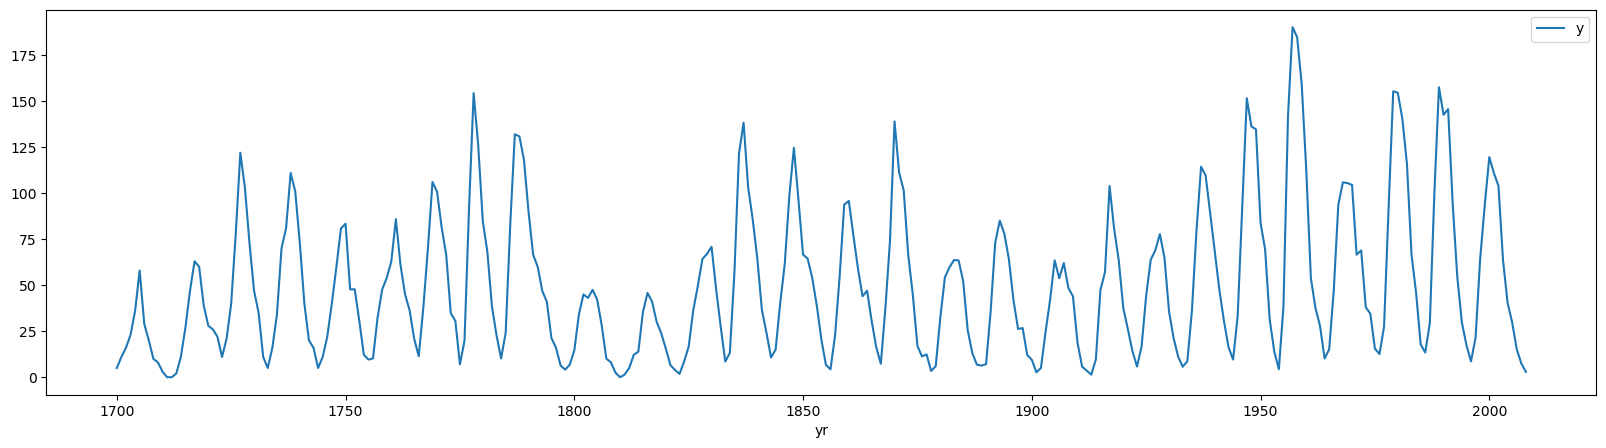

In [3]:
_ = df.plot(figsize=(20,5))
plt.show()

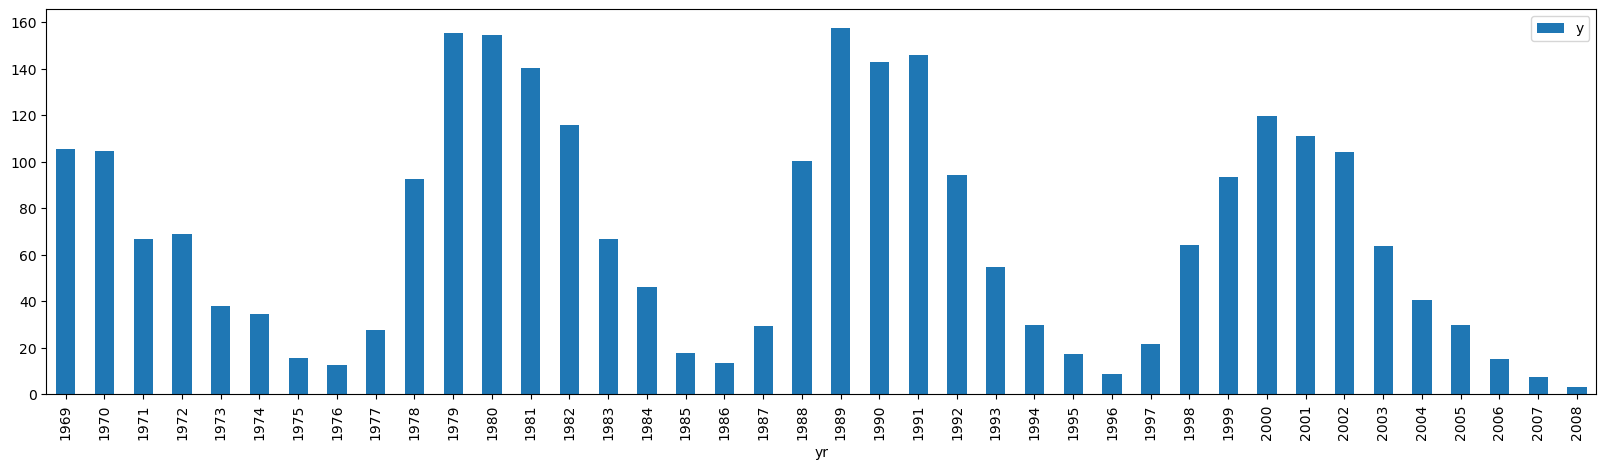

In [4]:
_ = df.tail(40).plot.bar(figsize=(20,5))
plt.show()

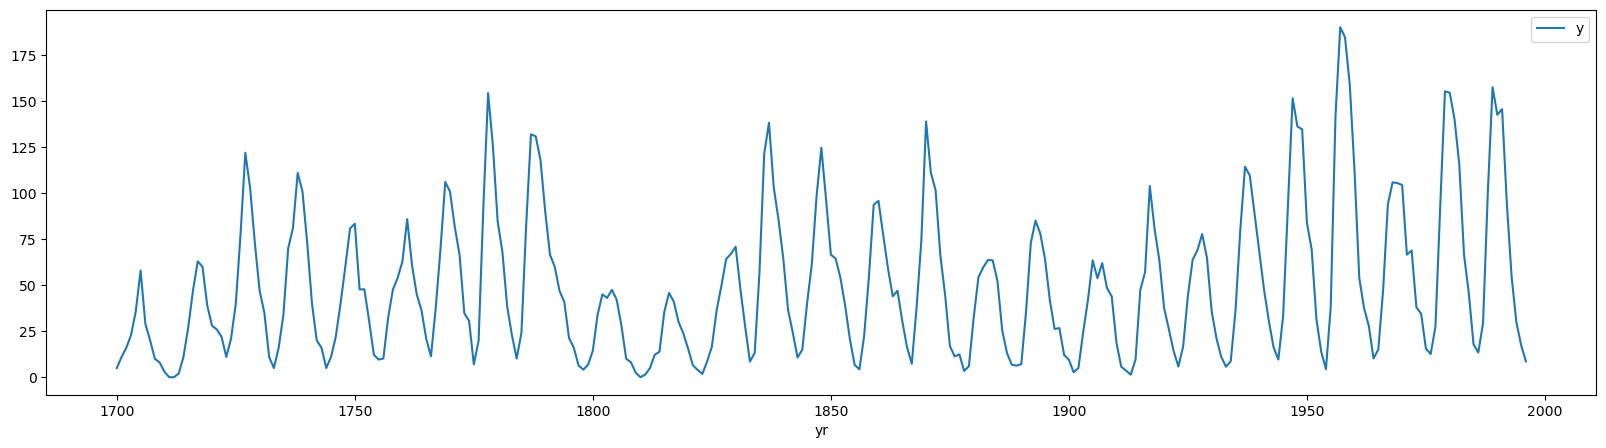

In [5]:
val = df.tail(12)
train = df.drop(val.index)
_ = train.plot(figsize=(20, 5))
plt.show()

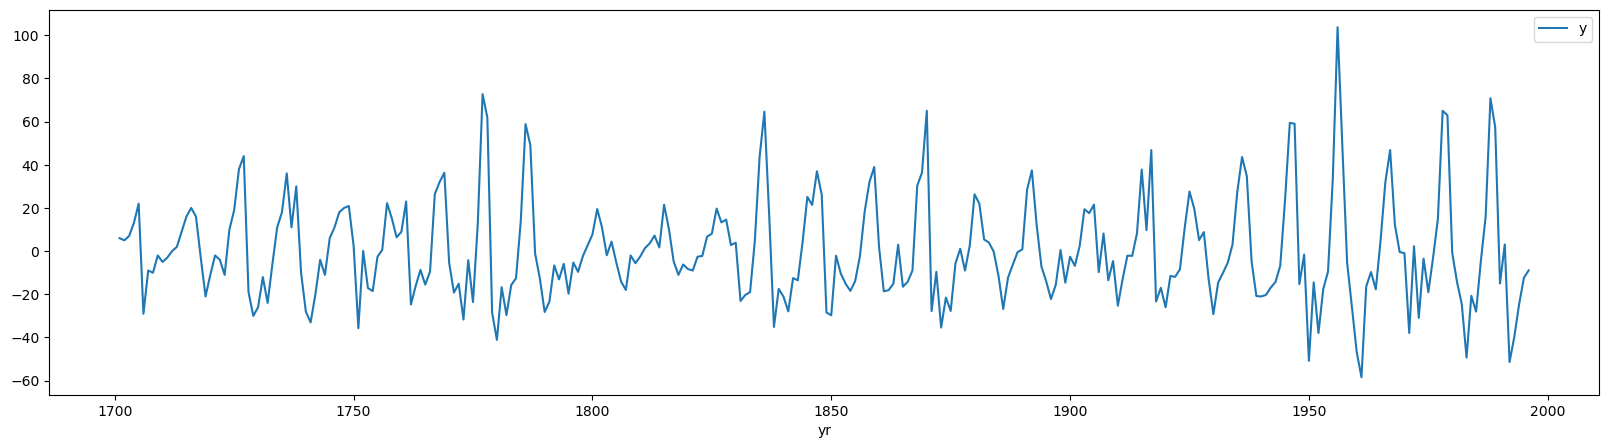

In [6]:
diff = train.diff(1)
_ = diff.plot(figsize=(20,5))
plt.show()

In [7]:
adf = ADFTest()
adf.should_diff(df.y.values)
# Even though ADF says not to difference, we should!

(0.01, False)

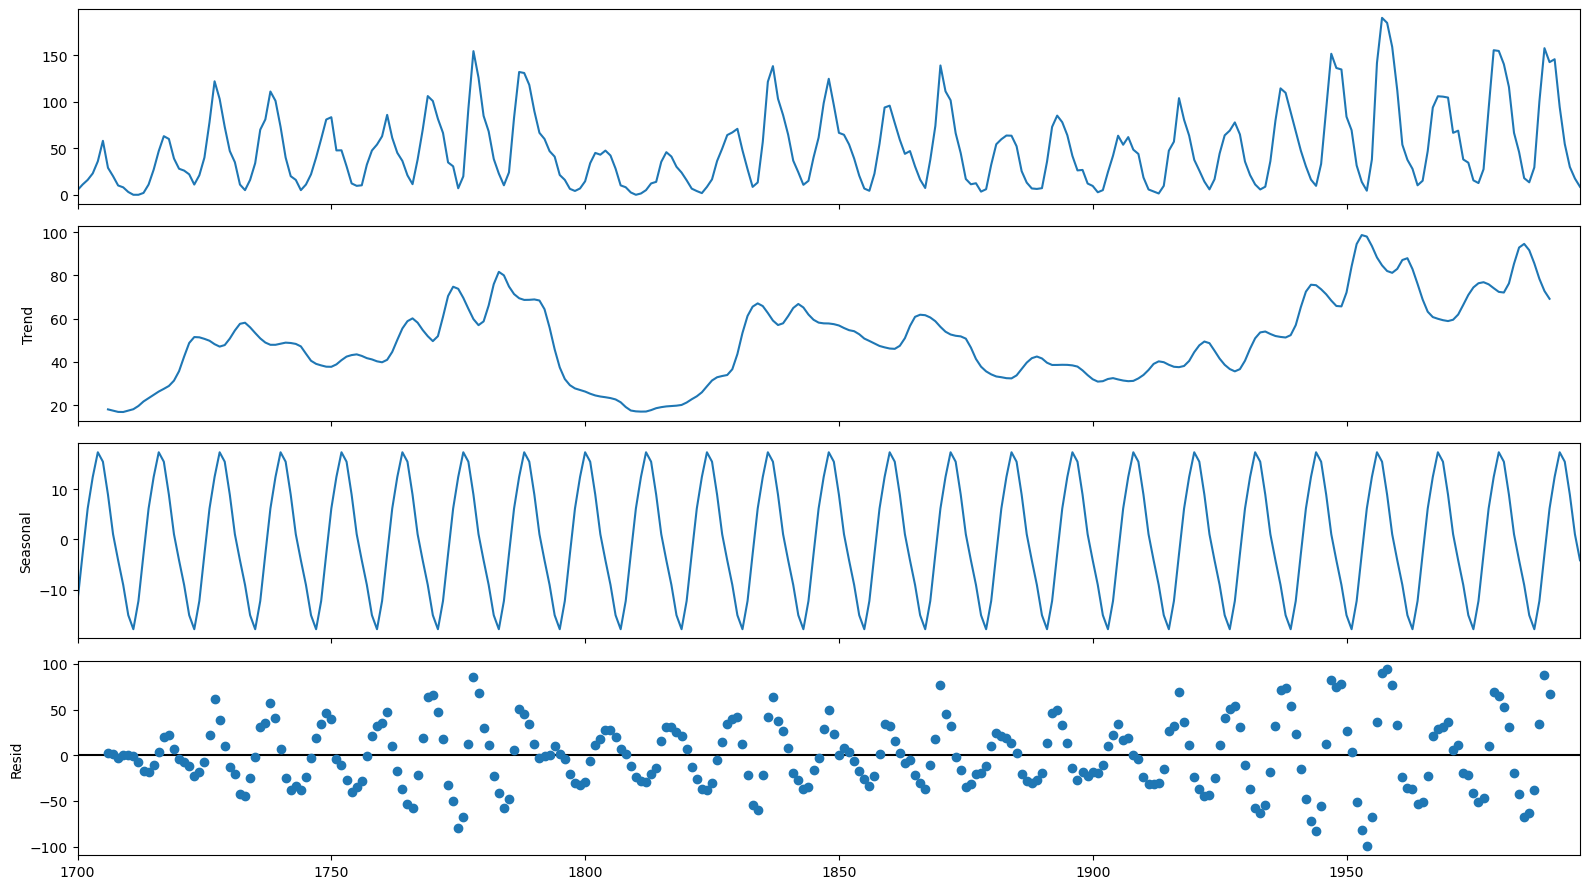

In [8]:
fig: Figure = seasonal_decompose(x=train, period=12).plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

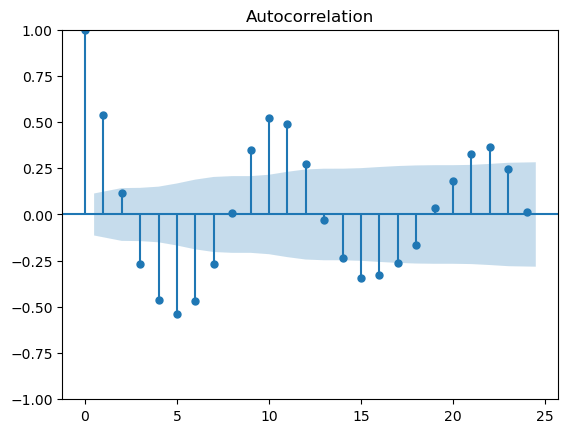

In [ ]:
#_ = sm.graphics.tsa.plot_acf(train, lags=40)
sm.graphics.tsa.plot_acf(train.y.diff(1).bfill().values.squeeze(), lags=24)
plt.show()
# Sinusoidal pattern with a period of 12

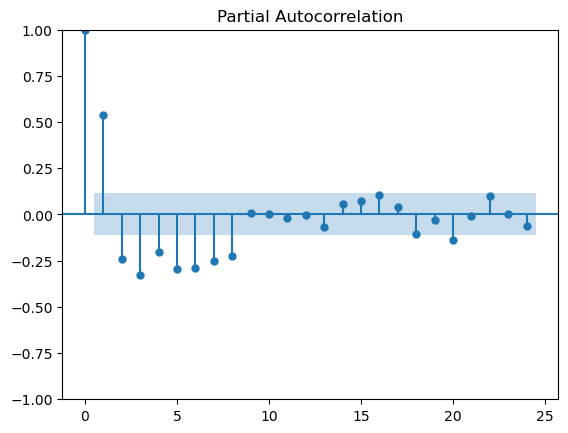

In [ ]:
# _ = sm.graphics.tsa.plot_pacf(train.values, lags=40)
sm.graphics.tsa.plot_pacf(train.y.diff(1).bfill().values.squeeze(), lags=24)
plt.show()
# The first 8 lags are significant, so we can try ARIMA(8, 1, 0)

In [43]:
stepwise_fit = pm.auto_arima(train,
                             start_P=0, max_P=8,
                             start_D=0, max_D=1,
                             start_Q=0, max_Q=8,
                             start_p=0, max_p=8,
                             start_d=0, max_d=1,
                             start_q=0, max_q=8,
                             seasonal_periods=12,
                             m=12,
                             seasonal=True,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True,
                             information_criterion='bic')

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=2733.358, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=2636.434, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=2641.682, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=2727.668, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : BIC=2638.517, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : BIC=2640.115, Time=0.30 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : BIC=2641.467, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : BIC=2635.782, Time=0.12 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : BIC=2641.453, Time=0.33 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : BIC=2642.616, Time=0.54 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : BIC=2715.615, Time=0.12 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : BIC=2623.188, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : BIC=2626.851, Time=0.09 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : BIC=2628.863, Time=0.26 sec
 ARIMA(2,1,0)(0,0,2

### Best fit

In [44]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  297
Model:               SARIMAX(8, 1, 0)   Log Likelihood               -1226.416
Date:                Thu, 15 May 2025   AIC                           2470.833
Time:                        15:04:37   BIC                           2504.046
Sample:                             0   HQIC                          2484.130
                                - 297                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1888      0.046      4.071      0.000       0.098       0.280
ar.L2         -0.2116      0.049     -4.312      0.000      -0.308      -0.115
ar.L3         -0.3568      0.061     -5.814      0.000      -0.477      -0.237
ar.L4         -0.2033      0.066     -3.076      0.002      -0.333      -0.074
ar.L5         -0.2867      0.061     -4.728      0.000      -0.406      -0.168
ar.L6         -0.2515      0.055     -4.605      0.000      -0.358      -0.144
ar.L7         -0.2122      0.060     -3.558      0.000      -0.329      -0.095
ar.L8         -0.2700      0.047     -5.752      0.000      -0.362      -0.178
sigma2       229.8527     16.160     14.223      0.000     198.179     261.527
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                38.87
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.54
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

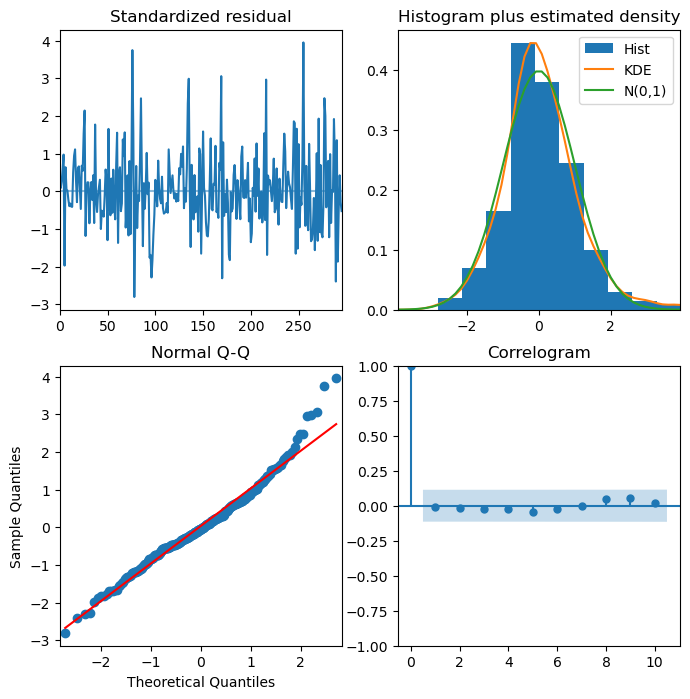

In [36]:
_ = stepwise_fit.plot_diagnostics(figsize=(8, 8))
plt.show()

df_train = pd.DataFrame(columns=['y', 'yhat'])
df_train.y = train.y.values
df_train.yhat = np.float32(stepwise_fit.fittedvalues())
df_train.index = train.index
_ = df_train.plot(figsize=(20, 5))

### Train Forecast

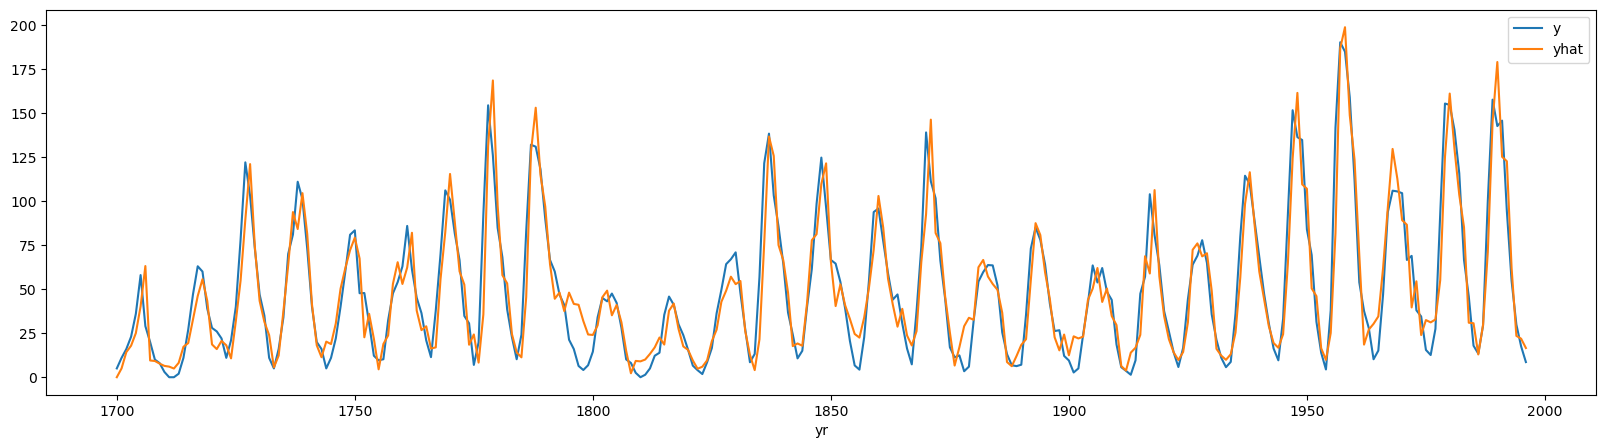

In [37]:
df_train = pd.DataFrame(columns=['y', 'yhat'])
df_train.y = train.y.values
df_train.yhat = stepwise_fit.fittedvalues().values
df_train.index = train.index
_ = df_train.plot(figsize=(20, 5))

### Validation Forecast vs. Actual

### Validation MAPE

In [38]:
forecast = np.float32(stepwise_fit.predict(n_periods=12))
pm.metrics.smape(val.y.values, forecast)

38.41947437559198

### Forecast to 2030

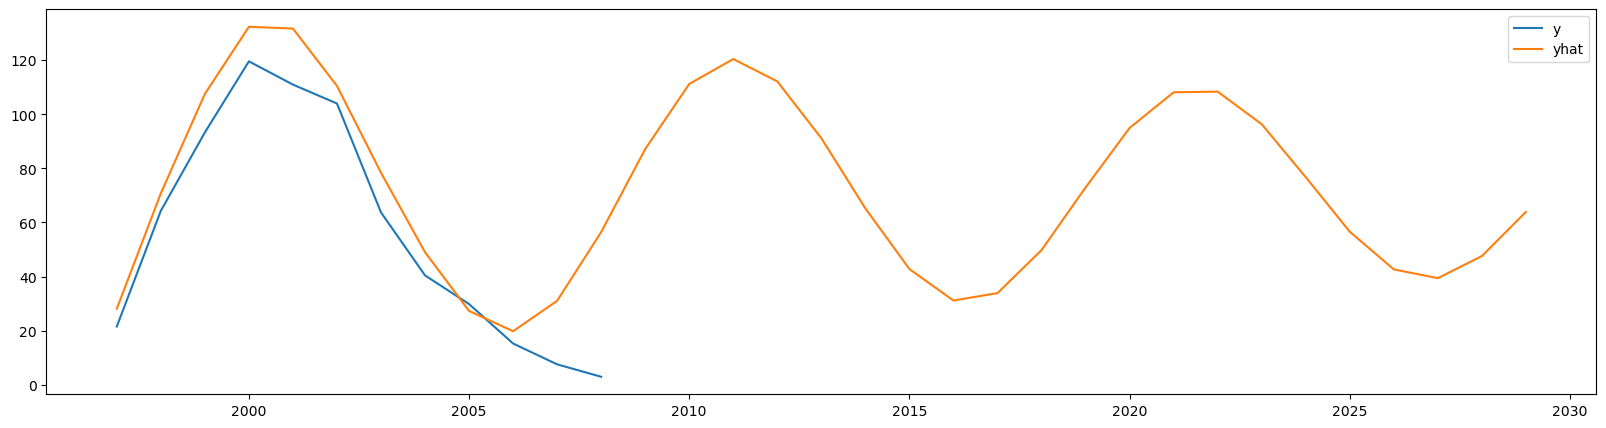

In [39]:
df_val = pd.DataFrame(columns=['y', 'yhat'])
df_val.y = np.concatenate([val.y.values, [None for i in range(0, 21)]])
df_val.yhat = np.float32(stepwise_fit.predict(n_periods=33))
df_val.index = np.concatenate([val.index, [i for i in range(2009, 2030)]])
_ = df_val.plot(figsize=(20,5))